In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV


In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
MSFT_m = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_message_10.csv", header=None)
MSFT_ob = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
MSFT_m['ticker'] = 'MSFT'
MSFT_ob['ticker'] = 'MSFT'

AMZN_m = pd.read_csv("./data/LOB_2012/AMZN_2012-06-21_34200000_57600000_message_10.csv", header=None)
AMZN_ob = pd.read_csv("./data/LOB_2012/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
AMZN_m['ticker'] = 'AMZN'
AMZN_ob['ticker'] = 'AMZN'

AAPL_m = pd.read_csv("./data/LOB_2012/AAPL_2012-06-21_34200000_57600000_message_10.csv", header=None)
AAPL_ob = pd.read_csv("./data/LOB_2012/AAPL_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
AAPL_m['ticker'] = 'AAPL'
AAPL_ob['ticker'] = 'AAPL'

INTC_m = pd.read_csv("./data/LOB_2012/INTC_2012-06-21_34200000_57600000_message_10.csv", header=None)
INTC_ob = pd.read_csv("./data/LOB_2012/INTC_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
INTC_m['ticker'] = 'INTC'
INTC_ob['ticker'] = 'INTC'

GOOG_m = pd.read_csv("./data/LOB_2012/GOOG_2012-06-21_34200000_57600000_message_10.csv", header=None)
GOOG_ob = pd.read_csv("./data/LOB_2012/GOOG_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
GOOG_m['ticker'] = 'GOOG'
GOOG_ob['ticker'] = 'GOOG'


df_m = pd.concat([MSFT_m, AMZN_m, AAPL_m, INTC_m, GOOG_m])
df_ob = pd.concat([MSFT_ob, AMZN_ob, AAPL_ob, INTC_ob, GOOG_ob])



In [4]:
M_header = ['time', 'event_type', 'order_ID',
            'size', 'price', 'direction', 'ticker']

df_m.columns = M_header


OB_header = []
for i in range(1, df_ob.shape[1]//4 + 1):
    OB_header.append(f'ask_price_{i}')
    OB_header.append(f'ask_size_{i}')
    OB_header.append(f'bid_price_{i}')
    OB_header.append(f'bid_size_{i}')

OB_header.append('ticker')

df_ob.columns = OB_header

In [5]:
df_m['time'] = pd.to_timedelta(df_m['time'], unit='s')

# Define the base date
base_date = pd.Timestamp('2012-06-21')

# Add the timedelta (time_sec) to the base date
df_m['datetime'] = base_date + df_m['time']

df_m.drop(columns=['time'], inplace=True)


In [6]:
# Creating event number
df_m['event_number'] = df_m.groupby('datetime').cumcount()
df_m['event_number_at_t'] = df_m.groupby('datetime')['event_type'].transform('count')

# Setting the composite index
df_m.set_index(['datetime', 'event_number', 'ticker'], inplace=True)

In [7]:
df_ob.index = df_m.index

In [8]:
df_ob['ask_price_1_prev'] = df_ob['ask_price_1'].shift()
df_ob['ask_size_1_prev'] = df_ob['ask_size_1'].shift()
df_ob['bid_price_1_prev'] = df_ob['bid_price_1'].shift()
df_ob['bid_size_1_prev'] = df_ob['bid_size_1'].shift()

In [9]:
# Define the start and end times
start_time = pd.to_datetime("09:15:00").time()
end_time = pd.to_datetime("15:45:00").time()

# Extract the 'datetime' level from the MultiIndex and filter based on the time
filtered_index = df_m.index.get_level_values('datetime').to_series().between_time(start_time, end_time).index

# Use the filtered index to get the filtered DataFrame
df_m_mh = df_m.loc[filtered_index]
df_ob_mh = df_ob.loc[filtered_index]

In [10]:
df_m_mh = df_m_mh[~df_m_mh.index.duplicated(keep='first')]
df_ob_mh = df_ob_mh[~df_ob_mh.index.duplicated(keep='first')]

Create features for ML prediction of direction

In [11]:
df_m_mh['midprice'] = (df_ob_mh['ask_price_1'] + df_ob_mh['bid_price_1']) / 2

In [12]:
df_m_mh['order_imb'] = (df_ob_mh['bid_size_1'] - df_ob_mh['ask_size_1']) / (df_ob_mh['bid_size_1'] + df_ob_mh['ask_size_1'])

We try to run ML models to predict the direction of hidden liquidity execution - these features mainly only make sense for event type 5

In [13]:
df_m_mh['prev_dir_t1'] = np.where(df_m_mh['event_type']==1, df_m_mh['direction'], np.nan)
df_m_mh['prev_dir_t1'] = df_m_mh['prev_dir_t1'].shift(1).ffill()
df_m_mh['prev_dir_t1'].fillna(0, inplace=True)

In [14]:
df_m_mh['next_dir_t1'] = np.where(df_m_mh['event_type']==1, df_m_mh['direction'], np.nan)
df_m_mh['next_dir_t1'] = df_m_mh['next_dir_t1'].shift(-1).bfill()
df_m_mh['next_dir_t1'].fillna(0, inplace=True)

In [15]:
df_m_mh['prev_dir_t4'] = np.where(df_m_mh['event_type']==4, df_m_mh['direction'], np.nan)
df_m_mh['prev_dir_t4'] = df_m_mh['prev_dir_t4'].shift(1).ffill()
df_m_mh['prev_dir_t4'].fillna(0, inplace=True)

In [16]:
df_m_mh['next_dir_t4'] = np.where(df_m_mh['event_type']==4, df_m_mh['direction'], np.nan)
df_m_mh['next_dir_t4'] = df_m_mh['next_dir_t4'].shift(-1).bfill()
df_m_mh['next_dir_t4'].fillna(0, inplace=True)

In [17]:
df_m_mh['next_dir_t3'] = np.where(df_m_mh['event_type']==3, df_m_mh['direction'], np.nan)
df_m_mh['next_dir_t3'] = df_m_mh['next_dir_t3'].shift(-1).bfill()
df_m_mh['next_dir_t3'].fillna(0, inplace=True)

In [18]:
df_m_mh['prev_dir_t3'] = np.where(df_m_mh['event_type']==3, df_m_mh['direction'], np.nan)
df_m_mh['prev_dir_t3'] = df_m_mh['prev_dir_t3'].shift(1).ffill()
df_m_mh['prev_dir_t3'].fillna(0, inplace=True)

In [19]:
df_ob_mh

ask_price_1  ask_size_1  \
datetime                      event_number ticker                            
2012-06-21 09:30:00.013994120 0            MSFT         309900        3788   
                              1            MSFT         309900        3788   
2012-06-21 09:30:00.015247805 0            MSFT         309900        3788   
2012-06-21 09:30:00.015442111 0            MSFT         309900        3788   
2012-06-21 09:30:00.015789148 0            MSFT         309900        3788   
...                                                        ...         ...   
2012-06-21 15:44:59.138324015 0            GOOG        5653400           2   
2012-06-21 15:44:59.202205321 0            GOOG        5653400           2   
2012-06-21 15:44:59.274086543 0            GOOG        5653400           2   
2012-06-21 15:44:59.274471626 0            GOOG        5653400          10   
2012-06-21 15:44:59.921326426 0            GOOG        5653400          10   

                                                   bid_price_1  bid_size_1  \
datetime                      event_number ticker                            
2012-06-21 09:30:00.013994120 0            MSFT         309500         300   
                              1            MSFT         309500         300   
2012-06-21 09:30:00.015247805 0            MSFT         309500         300   
2012-06-21 09:30:00.015442111 0            MSFT         309500         300   
2012-06-21 09:30:00.015789148 0            MSFT         309500         300   
...                                                        ...         ...   
2012-06-21 15:44:59.138324015 0            GOOG        5650000         202   
2012-06-21 15:44:59.202205321 0            GOOG        5650000         202   
2012-06-21 15:44:59.274086543 0            GOOG        5650000         202   
2012-06-21 15:44:59.274471626 0            GOOG        5650000         202   
2012-06-21 15:44:59.921326426 0            GOOG        5650000         202   

                                                   ask_price_2  ask_size_2  \
datetime                      event_number ticker                            
2012-06-21 09:30:00.013994120 0            MSFT         310500         100   
                              1            MSFT         310500         200   
2012-06-21 09:30:00.015247805 0            MSFT         310400         100   
2012-06-21 09:30:00.015442111 0            MSFT         310400         100   
2012-06-21 09:30:00.015789148 0            MSFT         310400         100   
...                                                        ...         ...   
2012-06-21 15:44:59.138324015 0            GOOG        5654200         100   
2012-06-21 15:44:59.202205321 0            GOOG        5654200         100   
2012-06-21 15:44:59.274086543 0            GOOG        5654200         100   
2012-06-21 15:44:59.274471626 0            GOOG        5654200         100   
2012-06-21 15:44:59.921326426 0            GOOG        5653600          16   

                                                   bid_price_2  bid_size_2  \
datetime                      event_number ticker                            
2012-06-21 09:30:00.013994120 0            MSFT         309300        3986   
                              1            MSFT         309300        3986   
2012-06-21 09:30:00.015247805 0            MSFT         309300        3986   
2012-06-21 09:30:00.015442111 0            MSFT         309300        3986   
2012-06-21 09:30:00.015789148 0            MSFT         309300        3986   
...                                                        ...         ...   
2012-06-21 15:44:59.138324015 0            GOOG        5648200         100   
2012-06-21 15:44:59.202205321 0            GOOG        5648200         100   
2012-06-21 15:44:59.274086543 0            GOOG        5648200         100   
2012-06-21 15:44:59.274471626 0            GOOG        5648200         100   
2012-06-21 15:44:59.921326426 0            GOOG        5648200        

Get overall sentiment at the current time point. We look at past 5 trades.
- pos if buy interest
- neg if sell interest

In [20]:
conditions = [
    (df_m_mh['event_type'] == 1),
    (df_m_mh['event_type'] == 3),
    (df_m_mh['event_type'] == 4)
]

# Define corresponding values
values = [
    df_m_mh['direction'],
    -df_m_mh['direction'],
    df_m_mh['direction']
]

# Apply np.select
df_m_mh['sentiment'] = np.select(conditions, values, default=0)

In [21]:
df_m_mh['agg_sentiment_prev'] = df_m_mh['sentiment'].rolling(window=5).sum()
df_m_mh['agg_sentiment_prev'] = df_m_mh['agg_sentiment_prev'].fillna(0)

df_m_mh['agg_sentiment_aft'] = df_m_mh['sentiment'].iloc[::-1].rolling(window=5).sum().iloc[::-1]
df_m_mh['agg_sentiment_aft'] = df_m_mh['agg_sentiment_aft'].iloc[::-1].fillna(0)



In [22]:
df_m_mh['agg_ratio'] = (df_m_mh['price'] - df_ob_mh['bid_price_1']) / (df_ob_mh['ask_price_1'] - df_ob_mh['bid_price_1'])

In [23]:
df_m_mh['hid_at_bid'] = (df_m_mh['price'] == df_ob_mh['bid_price_1']).astype(int) 
df_m_mh['hid_at_ask'] = (df_m_mh['price'] == df_ob_mh['ask_price_1']).astype(int)

We now specify the features we will use for prediction.

In [24]:
features_hid = df_m_mh[df_m_mh['event_type']==5]

We now drop features that are not relevant

In [25]:
features_hid.drop(columns=['event_type', 'order_ID', 'price', 'direction', 'midprice', 'sentiment'], inplace=True)

In [26]:
output_hid = df_m_mh[df_m_mh['event_type']==5]['direction']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features_hid, output_hid, test_size=0.25, random_state=42)

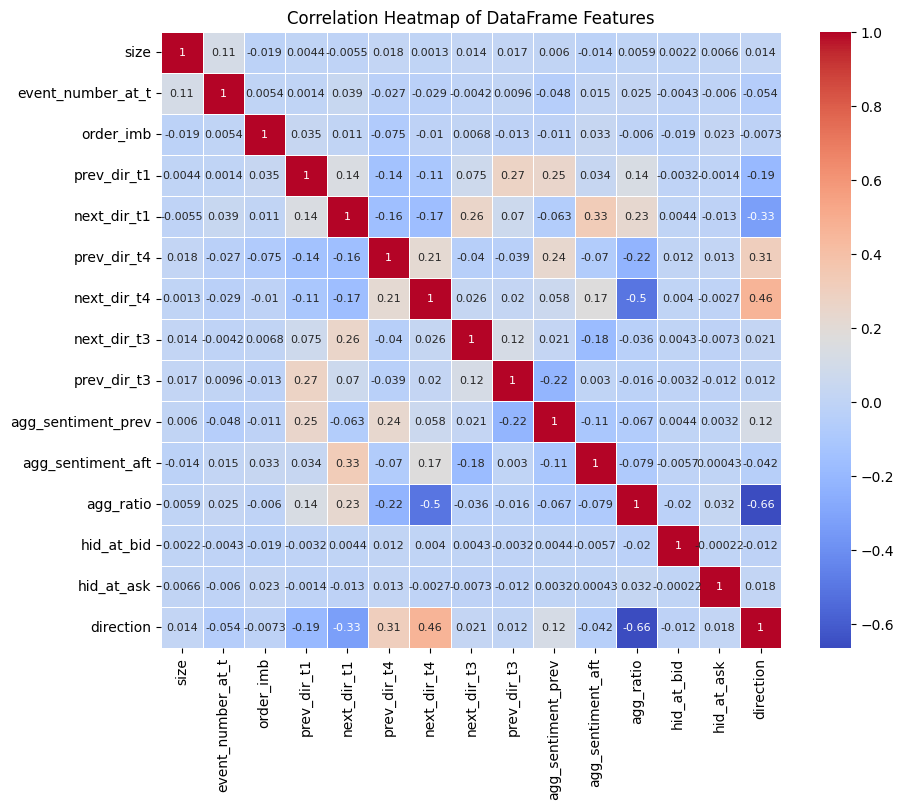

In [28]:
correlation_matrix = features_hid.merge(output_hid, left_index=True, right_index=True).corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of DataFrame Features')
plt.show()

## Random Forest Classifier

In [29]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [30]:
sum(y_pred == list(y_test))/len(y_pred)

np.float64(0.8581573896353167)

In [31]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Extract the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s

[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total tim

In [32]:
# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.87      0.87      2542
           1       0.88      0.87      0.87      2668

    accuracy                           0.87      5210
   macro avg       0.87      0.87      0.87      5210
weighted avg       0.87      0.87      0.87      5210



(array([2542.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2668.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

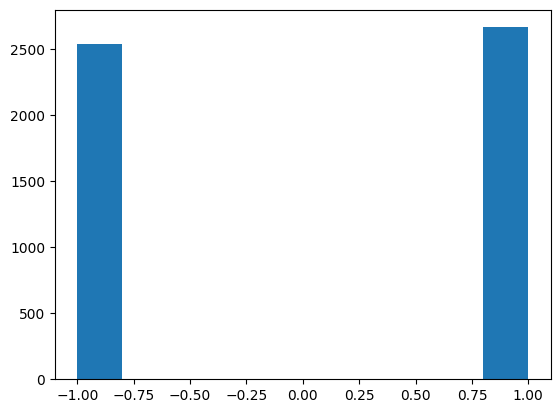

In [33]:
plt.hist(y_test)

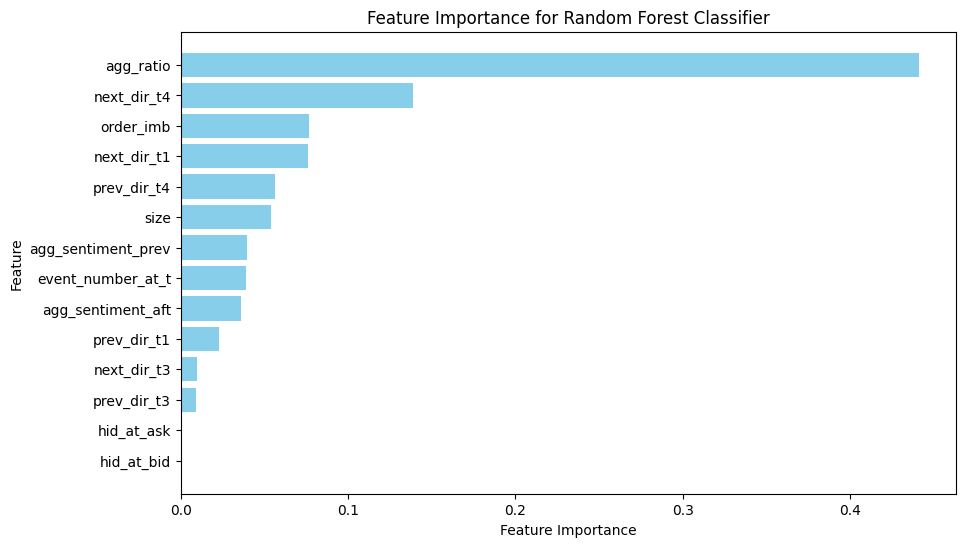

In [34]:
# Extract feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()

Logistic Regression

In [35]:
X_train_lr = X_train.drop(columns=['size', 'event_number_at_t'])
X_test_lr = X_test.drop(columns=['size', 'event_number_at_t'])

Accuracy: 0.8345489443378119
Confusion Matrix:
 [[2123  419]
 [ 443 2225]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.83      0.84      0.83      2542
           1       0.84      0.83      0.84      2668

    accuracy                           0.83      5210
   macro avg       0.83      0.83      0.83      5210
weighted avg       0.83      0.83      0.83      5210

ROC AUC Score: 0.9178670892720437


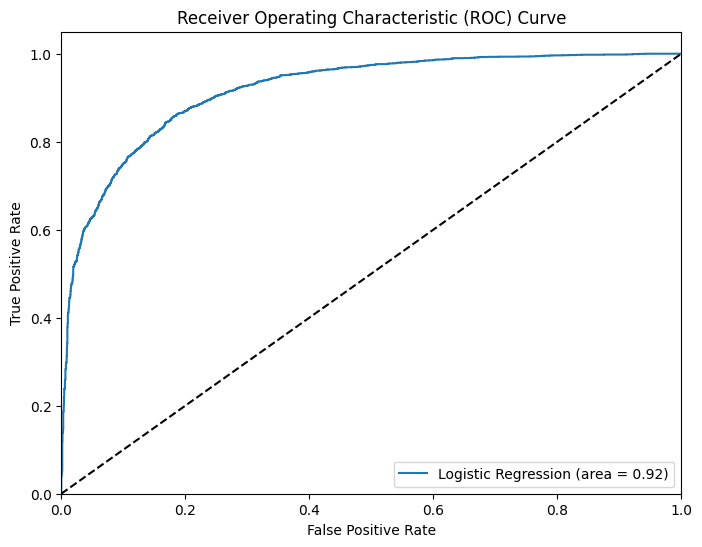

                    Coefficient
order_imb              0.101476
prev_dir_t1           -0.414580
next_dir_t1           -0.611272
prev_dir_t4            0.414619
next_dir_t4            0.465533
next_dir_t3            0.179167
prev_dir_t3            0.229181
agg_sentiment_prev     0.157864
agg_sentiment_aft     -0.011118
agg_ratio             -6.277536
hid_at_bid            -2.312927
hid_at_ask             2.497257


In [36]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(solver='liblinear')

# Fit the model to the training data
logreg.fit(X_train_lr, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test_lr)
y_pred_prob = logreg.predict_proba(X_test_lr)[:, 1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_pred_prob))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the model coefficients (feature importance)
coefficients = pd.DataFrame(logreg.coef_.flatten(), X_train_lr.columns, columns=['Coefficient'])
print(coefficients)

In [37]:
df_predicted_prob = pd.DataFrame(index=X_test_lr.index, data={'probabilities': y_pred_prob, 'predicted_dir':y_pred, 'true_dir':y_test})
df_predicted_prob

,,,probabilities,predicted_dir,true_dir
datetime,event_number,ticker,,,
2012-06-21 15:28:04.034923177,0,INTC,0.796216,1,1
2012-06-21 10:21:28.527662833,2,AAPL,0.991210,1,1
2012-06-21 14:47:44.394241923,0,INTC,0.137760,-1,-1
2012-06-21 14:03:02.297745768,0,INTC,0.384823,-1,-1
2012-06-21 15:38:38.345504779,0,INTC,0.213539,-1,-1
...,...,...,...,...,...
2012-06-21 09:52:04.992595849,0,AAPL,0.006773,-1,-1
2012-06-21 09:51:30.374351444,1,AAPL,0.946238,1,1
2012-06-21 13:52:42.651090805,1,AAPL,0.914330,1,1


In [38]:
df_predicted_prob['diff_from_rand'] = (df_predicted_prob['probabilities'] - 0.5).abs()
df_predicted_prob.sort_values(by='diff_from_rand')

,,,probabilities,predicted_dir,true_dir,diff_from_rand
datetime,event_number,ticker,,,,
2012-06-21 11:48:39.261491017,1,AAPL,0.499586,-1,1,0.000414
2012-06-21 10:53:38.180453059,0,MSFT,0.499358,-1,1,0.000642
2012-06-21 12:23:36.912921609,0,AAPL,0.501111,1,1,0.001111
2012-06-21 15:32:59.214826862,0,INTC,0.501122,1,1,0.001122
2012-06-21 13:41:39.254866627,0,AAPL,0.501382,1,-1,0.001382
...,...,...,...,...,...,...
2012-06-21 12:43:54.259217264,1,GOOG,0.996553,1,1,0.496553
2012-06-21 11:09:05.863813552,2,GOOG,0.996715,1,1,0.496715
2012-06-21 14:24:15.249327321,1,GOOG,0.003101,-1,-1,0.496899


In [39]:
specific_timestamp = pd.Timestamp('2012-06-21 11:48:39.261491017')
df_m_mh.index.get_loc((specific_timestamp, 1, 'AAPL'))
# SPY_m[SPY_m.index.get_level_values('datetime') == specific_timestamp]

1017786

Infer direction of hidden liquidity execution when there is an event type 4 happening at the same time frame (tag as same direction)

In [40]:
mult_event_hid_idx = df_m_mh.index.get_level_values('datetime').isin(df_m_mh[df_m_mh['event_number_at_t'] != 1].index.get_level_values('datetime'))

In [41]:
idx_mult_event_buy_vis = df_m_mh[mult_event_hid_idx][(df_m_mh[mult_event_hid_idx]['event_type'] == 4) & (df_m_mh[mult_event_hid_idx]['direction'] == 1)].index
idx_mult_event_sell_vis = df_m_mh[mult_event_hid_idx][(df_m_mh[mult_event_hid_idx]['event_type'] == 4) & (df_m_mh[mult_event_hid_idx]['direction'] == -1)].index

In [42]:
dt_mult_event_buy_vis = idx_mult_event_buy_vis.get_level_values('datetime').unique()
dt_mult_event_sell_vis = idx_mult_event_sell_vis.get_level_values('datetime').unique()

In [43]:
df_predicted_prob.loc[df_predicted_prob.index.get_level_values('datetime').isin(dt_mult_event_buy_vis), 'predicted_dir'] = 1
df_predicted_prob.loc[df_predicted_prob.index.get_level_values('datetime').isin(dt_mult_event_sell_vis), 'predicted_dir'] = -1

In [44]:
sum(df_predicted_prob['predicted_dir'] == df_predicted_prob['true_dir'])/len(df_predicted_prob)

0.8556621880998081

Infer direction of hidden liquidity execution when there is an event type 1 happening at the same time frame (tag as opposite direction)

In [45]:
idx_mult_sub_buy = df_m_mh[mult_event_hid_idx][(df_m_mh[mult_event_hid_idx]['event_type'] == 1) & (df_m_mh[mult_event_hid_idx]['direction'] == 1)].index
idx_mult_sub_sell = df_m_mh[mult_event_hid_idx][(df_m_mh[mult_event_hid_idx]['event_type'] == 1) & (df_m_mh[mult_event_hid_idx]['direction'] == -1)].index

In [46]:
dt_mult_sub_buy = idx_mult_sub_buy.get_level_values('datetime').unique()
dt_mult_sub_sell = idx_mult_sub_sell.get_level_values('datetime').unique()

In [47]:
df_predicted_prob.loc[df_predicted_prob.index.get_level_values('datetime').isin(dt_mult_sub_buy), 'predicted_dir'] = -1
df_predicted_prob.loc[df_predicted_prob.index.get_level_values('datetime').isin(dt_mult_sub_sell), 'predicted_dir'] = 1

In [48]:
sum(df_predicted_prob['predicted_dir'] == df_predicted_prob['true_dir'])/len(df_predicted_prob)

0.8573896353166987

Exploratory Data - for OFI

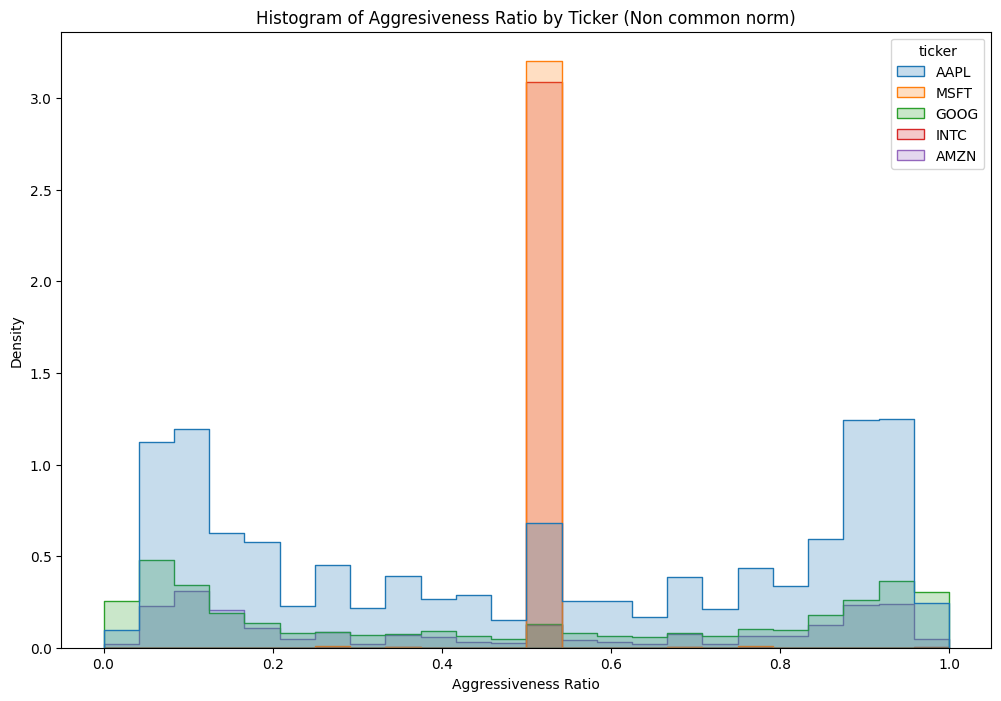

In [49]:
plt.figure(figsize=(12, 8))
sns.histplot(data=X_train, x='agg_ratio', hue='ticker', element='step', stat='density')

plt.xlabel('Aggressiveness Ratio')
plt.ylabel('Density')
plt.title('Histogram of Aggresiveness Ratio by Ticker (Non common norm)')
plt.show()

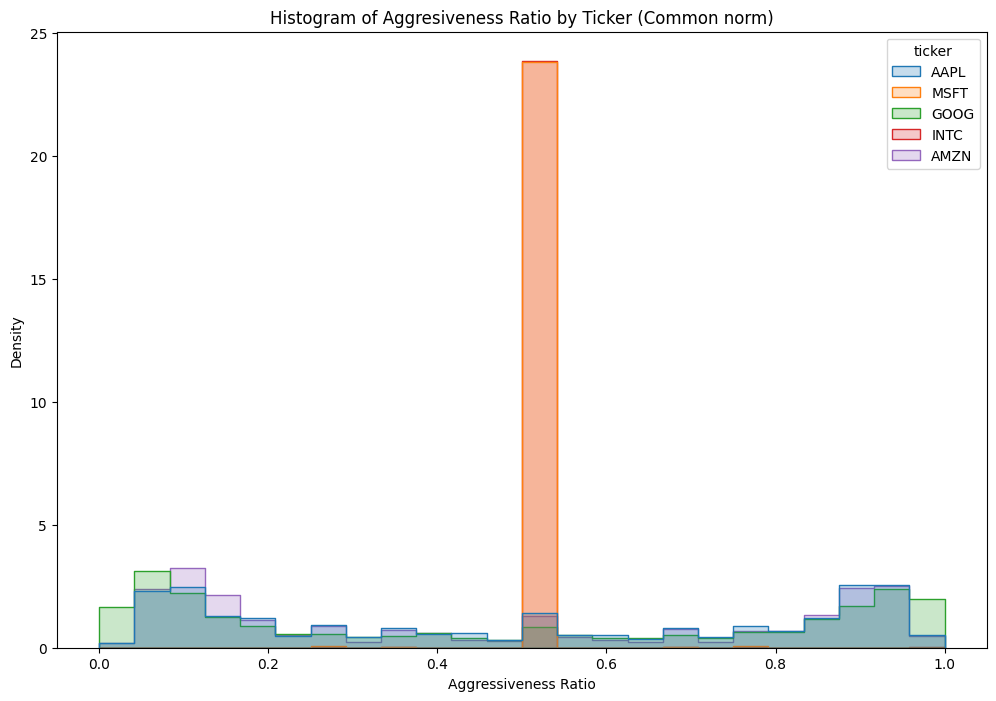

In [50]:
plt.figure(figsize=(12, 8))
sns.histplot(data=X_train, x='agg_ratio', hue='ticker', element='step', stat='density', common_norm=False)

plt.xlabel('Aggressiveness Ratio')
plt.ylabel('Density')
plt.title('Histogram of Aggresiveness Ratio by Ticker (Common norm)')
plt.show()

In [51]:
plt.bar(df_predicted_prob.groupby('ticker')['correct_pred'].mean().index, df_predicted_prob.groupby('ticker')['correct_pred'].mean())
plt.title("Accuracy by Ticker")

KeyError: 'Column not found: correct_pred'

We want to see the success probability of prediction by width of spread. This gives us a better idea of how well our ML model does depending on spread/ liquidity.

In [ ]:
df_predicted_analysis = df_predicted_prob.merge(df_ob_mh[['ask_price_1', 'bid_price_1']], left_index=True,
                                                     right_index=True)
df_predicted_analysis['BA_spread'] = df_predicted_analysis['ask_price_1'] - df_predicted_analysis['bid_price_1']

In [ ]:
df_predicted_analysis[['BA_spread', 'correct_pred']]

,,,BA_spread,correct_pred
datetime,event_number,ticker,,
2012-06-21 15:28:04.034923177,0,INTC,100,True
2012-06-21 10:21:28.527662833,2,AAPL,1900,True
2012-06-21 14:47:44.394241923,0,INTC,100,True
2012-06-21 14:03:02.297745768,0,INTC,100,True
2012-06-21 15:38:38.345504779,0,INTC,100,True
...,...,...,...,...
2012-06-21 09:52:04.992595849,0,AAPL,1300,True
2012-06-21 09:51:30.374351444,1,AAPL,1700,True
2012-06-21 13:52:42.651090805,1,AAPL,1100,True


In [ ]:
df_predicted_analysis['BA_spread'].unique()

array([  100,  1900,  2200,  2000,  3000,  1300,  1000,   900,  1200,
        1700,  4200,  2500,  1500,  1600,  1400,   200,  3500,   700,
         500,  2400,  1100,   600,  4900,  2300,   300,   800,  2100,
        3300,   400,  4000,  2900,  1800,  2600,  4600,  2700,  3700,
        3200,  3800,  3600,  3100,  4400,  4100,  2800,  3400,  4300,
        5400,  5100,  6000,  8500,  3900, 18700,  8000,  5200,  7600,
        4800, 17600,  6200,  4500,  5500,  4700, 15800,  8800, 19400,
       14500,  7800,  8200,  5800,  6700,  5900,  5000,  7500,  6300,
        5300, 23000,  7900, 20200,  8300])

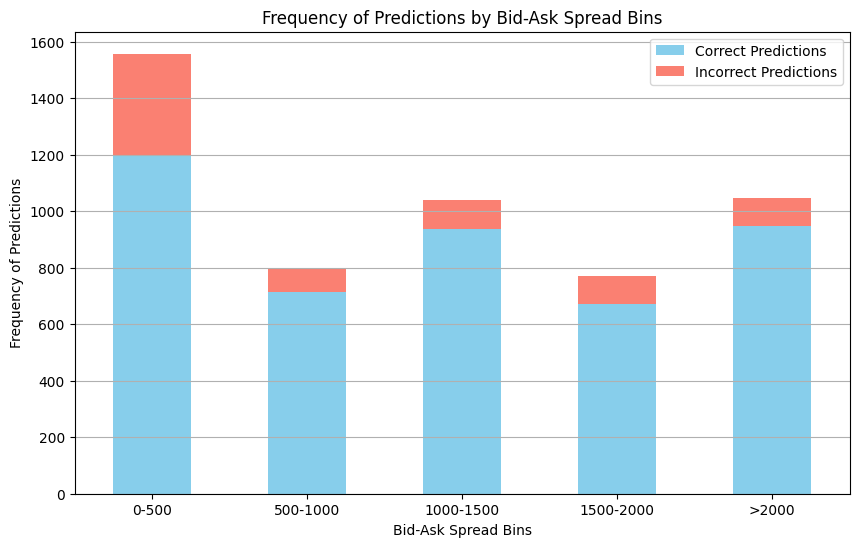

In [ ]:
# Binning the BA_spread column
bins = [0, 500, 1000, 1500, 2000, float('inf')]
labels = ['0-500', '500-1000', '1000-1500', '1500-2000', '>2000']
df_predicted_analysis['BA_spread_bins'] = pd.cut(df_predicted_analysis['BA_spread'], bins=bins, labels=labels)

# Grouping by BA_spread_bins and correct_pred
spread_counts = df_predicted_analysis.groupby(['BA_spread_bins', 'correct_pred']).size().unstack(fill_value=0)
spread_counts = spread_counts.T.reindex([True, False]).T  # Ensure the correct order

# Plotting
spread_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title('Frequency of Predictions by Bid-Ask Spread Bins')
plt.xlabel('Bid-Ask Spread Bins')
plt.ylabel('Frequency of Predictions')
plt.xticks(rotation=0)
plt.legend(['Correct Predictions', 'Incorrect Predictions'])
plt.grid(axis='y')

plt.show()

Most spreads are between 0-500 but we see that the model incorrectly predicts the direction the most for these too. This makes sense as the agg_ratio feature becomes less meaningful.

## OFI analysis

We first consider OFI decomposition in terms of lit and hidden order executions.

In [52]:
df_m_mh

event_type   order_ID  \
datetime                      event_number ticker                          
2012-06-21 09:30:00.013994120 0            MSFT             3   16085616   
                              1            MSFT             1   16116348   
2012-06-21 09:30:00.015247805 0            MSFT             1   16116658   
2012-06-21 09:30:00.015442111 0            MSFT             1   16116704   
2012-06-21 09:30:00.015789148 0            MSFT             1   16116752   
...                                                       ...        ...   
2012-06-21 15:44:59.138324015 0            GOOG             1  269563142   
2012-06-21 15:44:59.202205321 0            GOOG             3  268964028   
2012-06-21 15:44:59.274086543 0            GOOG             3  267636586   
2012-06-21 15:44:59.274471626 0            GOOG             1  269564638   
2012-06-21 15:44:59.921326426 0            GOOG             1  269569847   

                                                   size    price  direction  \
datetime                      event_number ticker                             
2012-06-21 09:30:00.013994120 0            MSFT     100   310400         -1   
                              1            MSFT     100   310500         -1   
2012-06-21 09:30:00.015247805 0            MSFT     100   310400         -1   
2012-06-21 09:30:00.015442111 0            MSFT     100   310500         -1   
2012-06-21 09:30:00.015789148 0            MSFT     100   310600         -1   
...                                                 ...      ...        ...   
2012-06-21 15:44:59.138324015 0            GOOG     100  5648200          1   
2012-06-21 15:44:59.202205321 0            GOOG     100  5645400          1   
2012-06-21 15:44:59.274086543 0            GOOG     100  5654600         -1   
2012-06-21 15:44:59.274471626 0            GOOG       8  5653400         -1   
2012-06-21 15:44:59.921326426 0            GOOG      16  5653600         -1   

                                                   event_number_at_t  \
datetime                      event_number ticker                      
2012-06-21 09:30:00.013994120 0            MSFT                    2   
                              1            MSFT                    2   
2012-06-21 09:30:00.015247805 0            MSFT                    1   
2012-06-21 09:30:00.015442111 0            MSFT                    1   
2012-06-21 09:30:00.015789148 0            MSFT                    1   
...                                                              ...   
2012-06-21 15:44:59.138324015 0            GOOG                    1   
2012-06-21 15:44:59.202205321 0            GOOG                    1   
2012-06-21 15:44:59.274086543 0            GOOG                    1   
2012-06-21 15:44:59.274471626 0            GOOG                    1   
2012-06-21 15:44:59.921326426 0            GOOG                    1   

                                                    midprice  order_imb  \
datetime                      event_number ticker                         
2012-06-21 09:30:00.013994120 0            MSFT     309700.0  -0.853229   
                              1            MSFT     309700.0  -0.853229   
2012-06-21 09:30:00.015247805 0            MSFT     309700.0  -0.853229   
2012-06-21 09:30:00.015442111 0            MSFT     309700.0  -0.853229   
2012-06-21 09:30:00.015789148 0            MSFT     309700.0  -0.853229   
...                                                      ...        ...   
2012-06-21 15:44:59.138324015 0            GOOG    5651700.0   0.980392   
2012-06-21 15:44:59.202205321 0            GOOG    5651700.0   0.980392   
2012-06-21 15:44:59.274086543 0            GOOG    5651700.0   0.980392   
2012-06-21 15:44:59.274471626 0            GOOG    5651700.0   0.905660   
2012-06-21 15:44:59.921326426 0            GOOG    5651700.0   0.905660   

                                                   prev_dir_t1  next_dir_t1  \
datetime                      event_number